# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [1]:
# Import required packages
import os
import json
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

### added lib
from tqdm.auto import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [3]:
datasets, vocab = load_wikitext()

Vocab size: 33175


#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [4]:
# reference from class Dictionary from lab code 
# creating a dictionary, this will be used when tokenizing the dataset

class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        # add every word in training set 
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
        
        # if we want to add valiation set, add this code as well
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
    
    ## this function is to add tokens 
    ## this addes tokens as well as idx and counts
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1
    
    # this function is called when we want to know the index of the token
    def get_id(self, w):
        return self.ids[w]
    
    # 
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)


In [5]:
# we call this function to create wiki_dict
# this contains token, id, count 
wiki_dict = Dictionary(datasets, include_valid=True)

  0%|          | 0/78274 [00:00<?, ?it/s]

  0%|          | 0/8464 [00:00<?, ?it/s]

In [6]:
# as expected, we get results as below examples 
print(len(wiki_dict))
for i in range(10):
    print(i, wiki_dict.get_token(i))

33181
0 <bos>
1 <eos>
2 <pad>
3 <unk>
4 Valkyria
5 of
6 the
7 Battlefield
8 3
9 )


In [7]:
# this code was also referenced by lab 4
## now moving on to creating a tokenized dataset

def tokenize_dataset(datasets, dictionary, ngram_order=2): 
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [8]:
# this code was also referenced by lab 4
# creating a dataset class that has input_tensors and target_tensors
# note that input_tensors and target_tensors are windowed by 1

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        return (self.input_tensors[idx], self.target_tensors[idx])

In [9]:
# generate tokenized dataset
wiki_tokenized_datasets = tokenize_dataset(datasets, wiki_dict)

# now, create a tensored_tokenized dataset
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# first example
wiki_tensor_dataset['train'][0]

  0%|          | 0/78274 [00:00<?, ?it/s]

  0%|          | 0/8464 [00:00<?, ?it/s]

  0%|          | 0/9708 [00:00<?, ?it/s]

(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [10]:
# this code was also referenced by lab 4

def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('<pad>') # 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [11]:
wiki_loaders = {}

batch_size = 128 #128 

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     collate_fn=pad_collate_fn)

#### Model + Training (5 pts)

In [12]:
# create a LSTM model that is very similar to RNN model that was covered in the lab 

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, lstm and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        # for the first part, we need embeddings to make each words as list of embeddings
        # then we set a lstm 
        # then we take a projection 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['lstm_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # [batch_size, sen_length]
        embeddings = self.lookup(encoded_input_sequence)
        # [batch_size, sen_length, embed_length]
        lstm_outputs = self.lstm(embeddings)
        # [batch_size, sen_length, state_dim]
        logits = self.projection(lstm_outputs[0]) #convenient for seq to seq models. check shape of output. lstm gives different
        
        return logits

#### Experiment 1: hidden_size = 512

In [17]:
# Create a model if we do not want to use pretrained model

load_pretrained = False # False or True
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    current_device = 'cuda' 
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('/home/yp2201/wiki_lstm_lm_512.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('/home/yp2201/wiki_lstm_lm_512.pt', map_location=current_device) # change the path 
    
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    # this is example parameters, and different values will be used 
    embedding_size = 256
    hidden_size = 512   ## This is the parameter that i am changing 
    num_layers = 3
    lstm_dropout = 0.3

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
    }


    model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [18]:
### This is for 

plot_cache = []

# add variables for early stopping
# max_patience : if the validation performance does not improve for m epochs, terminate the training process
# early_stop: this will be use to determine if the training has reached the early stopping point 

max_patience = 3 
init_loss = float('inf')
num_epochs = 100

for epoch_number in range(num_epochs):
    
    # if there are already pretrained model
    if load_pretrained:
        break    
    
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
#                 print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    # defining early stopping point
    # if given loss is less than the init loss, then update the best model
    # also, change the init_loss
    if avg_val_loss < init_loss:
        best_model = model
        best_epoch = epoch_number
        stop_epoch_cnt = 0
        init_loss = avg_val_loss
    
    # if not, just add stop count. 
    else:
        stop_epoch_cnt += 1

    

    # when training meets early stop point, save best model and exit training loop 
    if stop_epoch_cnt >= max_patience:
        print('Early stopped at epoch: ', best_epoch)
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': best_model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_512.pt')
        break

    # if you was not able to save early-stopping point,
    # then save the final epoch of the model 
    if epoch_number == (num_epochs -1):
        print('Did not Early stopped. Saving the model at the last epoch ')
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_512.pt')

Validation loss after 0 epoch = 7.8501
Validation loss after 1 epoch = 7.4869
Validation loss after 2 epoch = 7.1811
Validation loss after 3 epoch = 6.9255
Validation loss after 4 epoch = 6.7055
Validation loss after 5 epoch = 6.5526
Validation loss after 6 epoch = 6.4181
Validation loss after 7 epoch = 6.3147
Validation loss after 8 epoch = 6.2261
Validation loss after 9 epoch = 6.1406
Validation loss after 10 epoch = 6.0671
Validation loss after 11 epoch = 5.9973
Validation loss after 12 epoch = 5.9340
Validation loss after 13 epoch = 5.8708
Validation loss after 14 epoch = 5.8193
Validation loss after 15 epoch = 5.7715
Validation loss after 16 epoch = 5.7283
Validation loss after 17 epoch = 5.6803
Validation loss after 18 epoch = 5.6433
Validation loss after 19 epoch = 5.6057
Validation loss after 20 epoch = 5.5791
Validation loss after 21 epoch = 5.5423
Validation loss after 22 epoch = 5.5156
Validation loss after 23 epoch = 5.4869
Validation loss after 24 epoch = 5.4624
Validation

#### Experiment 2: hidden_size = 256

In [16]:
# Create a model if we do not want to use pretrained model

load_pretrained = False # False or True
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    current_device = 'cuda' 
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('/home/yp2201/wiki_lstm_lm_256.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('/home/yp2201/wiki_lstm_lm_256.pt', map_location=current_device) # change the path 
    
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    # this is example parameters, and different values will be used 
    embedding_size = 256
    hidden_size = 256   ## This is the parameter that i am changing 
    num_layers = 3
    lstm_dropout = 0.3

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
    }


    model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [17]:
## experiment2: case of hid_size = 256

plot_cache = []

# add variables for early stopping
# max_patience : if the validation performance does not improve for m epochs, terminate the training process
# early_stop: this will be use to determine if the training has reached the early stopping point 

max_patience = 3 
init_loss = float('inf')
num_epochs = 100

for epoch_number in range(num_epochs):
    
    # if there are already pretrained model
    if load_pretrained:
        break    
    
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
#                 print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    # defining early stopping point
    if avg_val_loss < init_loss:
        best_model = model
        best_epoch = epoch_number
        stop_epoch_cnt = 0
        init_loss = avg_val_loss
    else:
        stop_epoch_cnt += 1

    # when training meets early stop point, save best model and exit training loop 
    if stop_epoch_cnt >= max_patience:
        print('Early stopped at epoch: ', best_epoch)
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': best_model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_256.pt')
        break

    # if you was not able to save early-stopping point,
    # then save the final epoch of the model 
    if epoch_number == (num_epochs -1):
        print('Did not Early stopped. Saving the model at the last epoch ')
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_256.pt')

Validation loss after 0 epoch = 7.8500
Validation loss after 1 epoch = 7.5624
Validation loss after 2 epoch = 7.3595
Validation loss after 3 epoch = 7.0814
Validation loss after 4 epoch = 6.8470
Validation loss after 5 epoch = 6.6604
Validation loss after 6 epoch = 6.5289
Validation loss after 7 epoch = 6.4217
Validation loss after 8 epoch = 6.3373
Validation loss after 9 epoch = 6.2595
Validation loss after 10 epoch = 6.1954
Validation loss after 11 epoch = 6.1301
Validation loss after 12 epoch = 6.0744
Validation loss after 13 epoch = 6.0183
Validation loss after 14 epoch = 5.9680
Validation loss after 15 epoch = 5.9196
Validation loss after 16 epoch = 5.8765
Validation loss after 17 epoch = 5.8422
Validation loss after 18 epoch = 5.8070
Validation loss after 19 epoch = 5.7772
Validation loss after 20 epoch = 5.7477
Validation loss after 21 epoch = 5.7167
Validation loss after 22 epoch = 5.6916
Validation loss after 23 epoch = 5.6714
Validation loss after 24 epoch = 5.6454
Validation

#### Experiment 3: hidden_size = 128

In [18]:
# Create a model if we do not want to use pretrained model

load_pretrained = False # False or True
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    current_device = 'cuda' 
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('/home/yp2201/wiki_lstm_lm_128.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('/home/yp2201/wiki_lstm_lm_128.pt', map_location=current_device) # change the path 
    
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    # this is example parameters, and different values will be used 
    embedding_size = 128
    hidden_size = 128   ## This is the parameter that i am changing 
    num_layers = 3
    lstm_dropout = 0.3

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
    }


    model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [19]:
### This is for hid_size 128

plot_cache = []

# add variables for early stopping
# max_patience : if the validation performance does not improve for m epochs, terminate the training process
# early_stop: this will be use to determine if the training has reached the early stopping point 

max_patience = 3 
init_loss = float('inf')
num_epochs = 100

for epoch_number in range(num_epochs):
    
    # if there are already pretrained model
    if load_pretrained:
        break    
    
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
#                 print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    # defining early stopping point
    if avg_val_loss < init_loss:
        best_model = model
        best_epoch = epoch_number
        stop_epoch_cnt = 0
        init_loss = avg_val_loss        
    else:
        stop_epoch_cnt += 1

    # when training meets early stop point, save best model and exit training loop 
    if stop_epoch_cnt >= max_patience:
        print('Early stopped at epoch: ', best_epoch)
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': best_model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_128.pt')
        break

    # if you was not able to save early-stopping point,
    # then save the final epoch of the model 
    if epoch_number == (num_epochs -1):
        print('Did not Early stopped. Saving the model at the last epoch ')
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_128.pt')

Validation loss after 0 epoch = 7.9228
Validation loss after 1 epoch = 7.6143
Validation loss after 2 epoch = 7.4691
Validation loss after 3 epoch = 7.2670
Validation loss after 4 epoch = 7.0087
Validation loss after 5 epoch = 6.8179
Validation loss after 6 epoch = 6.6815
Validation loss after 7 epoch = 6.5699
Validation loss after 8 epoch = 6.4797
Validation loss after 9 epoch = 6.4158
Validation loss after 10 epoch = 6.3596
Validation loss after 11 epoch = 6.3131
Validation loss after 12 epoch = 6.2819
Validation loss after 13 epoch = 6.2429
Validation loss after 14 epoch = 6.2065
Validation loss after 15 epoch = 6.1799
Validation loss after 16 epoch = 6.1460
Validation loss after 17 epoch = 6.1165
Validation loss after 18 epoch = 6.0890
Validation loss after 19 epoch = 6.0561
Validation loss after 20 epoch = 6.0345
Validation loss after 21 epoch = 6.0045
Validation loss after 22 epoch = 5.9820
Validation loss after 23 epoch = 5.9568
Validation loss after 24 epoch = 5.9403
Validation

#### Experiment 4: hidden_size = 1024

In [20]:
# Create a model if we do not want to use pretrained model

load_pretrained = False # False or True
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    current_device = 'cuda' 
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('/home/yp2201/wiki_lstm_lm_1024.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('/home/yp2201/wiki_lstm_lm_1024.pt', map_location=current_device) # change the path 
    
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    # this is example parameters, and different values will be used 
    embedding_size = 1024
    hidden_size = 1024   ## This is the parameter that i am changing 
    num_layers = 3
    lstm_dropout = 0.3

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
    }

    model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [21]:
### This is for hid_size = 1024

plot_cache = []

# add variables for early stopping
# max_patience : if the validation performance does not improve for m epochs, terminate the training process
# early_stop: this will be use to determine if the training has reached the early stopping point 

max_patience = 3 
init_loss = float('inf')
num_epochs = 100

for epoch_number in range(num_epochs):
    
    # if there are already pretrained model
    if load_pretrained:
        break    
    
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
#                 print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    # defining early stopping point
    if avg_val_loss < init_loss:
        best_model = model
        best_epoch = epoch_number
        stop_epoch_cnt = 0
        init_loss = avg_val_loss        
    else:
        stop_epoch_cnt += 1

    # when training meets early stop point, save best model and exit training loop 
    if stop_epoch_cnt >= max_patience:
        print('Early stopped at epoch: ', best_epoch)
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': best_model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_1024.pt')
        break

    # if you was not able to save early-stopping point,
    # then save the final epoch of the model 
    if epoch_number == (num_epochs -1):
        print('Did not Early stopped. Saving the model at the last epoch ')
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': model.state_dict()
        }, '/home/yp2201/wiki_lstm_lm_1024.pt')

Validation loss after 0 epoch = 7.8418
Validation loss after 1 epoch = 7.2855
Validation loss after 2 epoch = 6.9238
Validation loss after 3 epoch = 6.6212
Validation loss after 4 epoch = 6.4416
Validation loss after 5 epoch = 6.2811
Validation loss after 6 epoch = 6.1529
Validation loss after 7 epoch = 6.0468
Validation loss after 8 epoch = 5.9400
Validation loss after 9 epoch = 5.8501
Validation loss after 10 epoch = 5.7644
Validation loss after 11 epoch = 5.6859
Validation loss after 12 epoch = 5.6202
Validation loss after 13 epoch = 5.5595
Validation loss after 14 epoch = 5.5097
Validation loss after 15 epoch = 5.4622
Validation loss after 16 epoch = 5.4175
Validation loss after 17 epoch = 5.3698
Validation loss after 18 epoch = 5.3416
Validation loss after 19 epoch = 5.3084
Validation loss after 20 epoch = 5.2858
Validation loss after 21 epoch = 5.2476
Validation loss after 22 epoch = 5.2320
Validation loss after 23 epoch = 5.2040
Validation loss after 24 epoch = 5.1860
Validation

In [22]:
## load all models
model_512 = torch.load('/home/yp2201/wiki_lstm_lm_512.pt')
model_256 = torch.load('/home/yp2201/wiki_lstm_lm_256.pt')
model_128 = torch.load('/home/yp2201/wiki_lstm_lm_128.pt')
model_1024 = torch.load('/home/yp2201/wiki_lstm_lm_1024.pt')

#### Performance variation based on hyper-parameter values (5 pts)


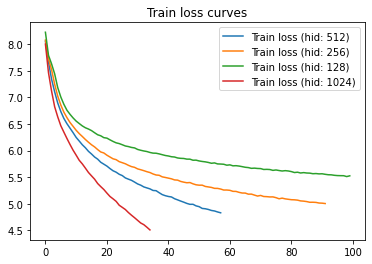

In [23]:
import numpy as np

plt.plot([i[0] for i in model_512['loss_cache']], label='Train loss (hid: 512)')
plt.plot([i[0] for i in model_256['loss_cache']], label='Train loss (hid: 256)')
plt.plot([i[0] for i in model_128['loss_cache']], label='Train loss (hid: 128)')
plt.plot([i[0] for i in model_1024['loss_cache']], label='Train loss (hid: 1024)')

plt.legend()
plt.title('Train loss curves')
plt.show()    

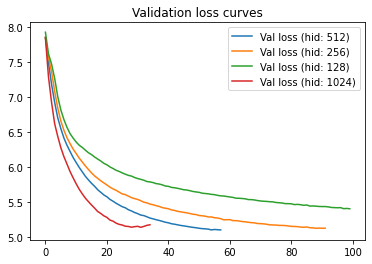

In [24]:
## Based on the valiation performance among models, I've selected hidden_size = 512 as a best model
# hid_128: Validation loss after 99 epoch = 5.4087
# hid_256: Validation loss after 88 epoch = 5.1304
# hid_512: Validation loss after 54 epoch = 5.1075
# hid_1024: Validation loss after 31 epoch = 5.1447

import numpy as np

plt.plot([i[1] for i in model_512['loss_cache']], label='Val loss (hid: 512)')
plt.plot([i[1] for i in model_256['loss_cache']], label='Val loss (hid: 256)')
plt.plot([i[1] for i in model_128['loss_cache']], label='Val loss (hid: 128)')
plt.plot([i[1] for i in model_1024['loss_cache']], label='Val loss (hid: 1024)')

plt.legend()
plt.title('Validation loss curves')
plt.show()    

In [25]:
## Also, define best model so that we can use this model for next questions 
model_dict = torch.load('/home/yp2201/wiki_lstm_lm_512.pt', map_location=current_device) # change the path 
options = model_dict['options']
model = LSTMLanguageModel(options).to(current_device)
model.load_state_dict(model_dict['model_dict'])

<All keys matched successfully>

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [26]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [27]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/share/apps/python/3.8.6/intel/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


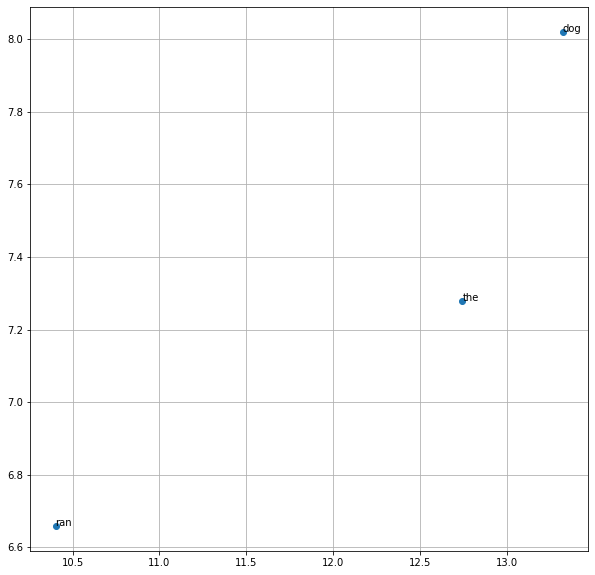

In [28]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### 2.1 Word similarity (3 pts)


In [31]:
'''
Choose a set of 4 works, e.g., {run, dog, where, quick}. 
For each word, find the 10 closest words and 10 furthest words in the trained 
LSTM model’s final projection layer according to cosine similarity. 
You will need to implement your own cosine similarity function. (3 pts)
'''

# define Vsize, dimension, weight_matrix
# weight_matrix contains embeddings for each word
# this means that we can find the most similary embedding for each word
Vsize = len(wiki_dict)

d = model.projection.weight.size(1)
weight_matrix = model.projection.weight

# first, we want to know words - index that is defined in our wiki_dict
# {'run': 3636, 'dog': 5388, 'where': 163, 'quick': 1690}
words = ['run', 'dog', 'where', 'quick']
word_dict = {}
for word in words: 
    word_dict[word] = wiki_dict.get_id(word)
    
# now given index embedding, define cos_sim function that returns similarity score 
def cos_sim(word_idx, ref_idx):
    list_a = weight_matrix[word_idx].detach().cpu().numpy()
    list_b = weight_matrix[ref_idx].detach().cpu().numpy()
    
    cos_sim_score = np.dot(list_a,list_b)/((norm(list_a)*norm(list_b)))
    
    return cos_sim_score


# for each word, check sim_score for all words in wiki_dict
# then print out top 10 close/far words given target word

# this is needed in question 2
related_word_list = []

for word, word_idx in word_dict.items():
    sim_score = {}
    # this is to ignore <bos>, <eos>, <pad>, <unk>
    for ref_idx in range(4, Vsize):
        sim_score[wiki_dict.get_token(ref_idx)] = cos_sim(word_idx, ref_idx)
        
    close_words = dict(list(sorted(sim_score.items(), key=lambda item: item[1], reverse=True))[1:11])
    further_words = dict(list(sorted(sim_score.items(), key=lambda item: item[1]))[:10])
    
    # use extend to make one list 
    related_word_list.extend(list(close_words.keys()))
    related_word_list.extend(list(further_words.keys()))
    
    print('=========RESULT=========')
    print(word)
    print('Close 10 top words:')
    print(close_words)
    print()
    print('Far 10 top words:')
    print(further_words)
    print()    

=========RESULT=========
run
Close 10 top words:
{'pass': 0.6370318, 'drive': 0.6332831, 'deal': 0.59699416, 'win': 0.5855623, 'play': 0.57692116, 'match': 0.5757888, 'stop': 0.57095724, 'campaign': 0.55919915, 'move': 0.54972816, 'visit': 0.54227906}

Far 10 top words:
{'europaeus': -0.3085718, 'Prism': -0.30350292, 'lupus': -0.30346975, 'CHR': -0.3028563, 'calospora': -0.30050015, 'Binh': -0.29142722, 'sud': -0.2906273, 'Giles': -0.28940132, 'Émile': -0.28918272, 'Imperioli': -0.28896073}

=========RESULT=========
dog
Close 10 top words:
{'depiction': 0.51344395, 'fox': 0.50922054, 'message': 0.50387347, 'woman': 0.50045955, 'narrative': 0.49382448, 'wedding': 0.49342328, 'portrait': 0.49141005, 'desire': 0.49131003, 'hero': 0.4885246, 'girl': 0.48535383}

Far 10 top words:
{'Township': -0.4232492, 'Avenue': -0.40427306, 'Rapids': -0.37123275, 'a.m.': -0.3652697, 'peaking': -0.3631055, 'Canyon': -0.36107212, 'Flow': -0.36053333, 'Mile': -0.35253647, 'Cove': -0.35131896, 'p.m.': -0.34

#### 2.2 UMAP (3 pts)

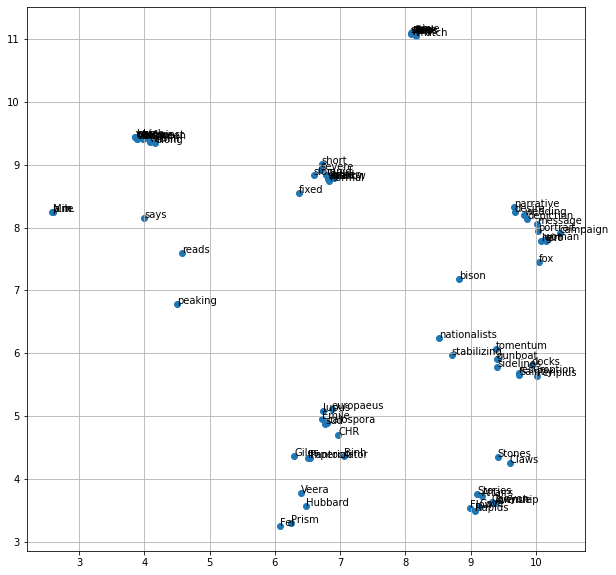

In [32]:
# use umap function 
# words: 'ran', 'dog', 'where', 'quick'
related_word_ids = [wiki_dict.get_id(x) for x in related_word_list]

umap_plot(weight_matrix, related_word_ids, related_word_list)

---
### 3 Sampling (14 pts)


#### 3.1 Sampling implementation (4 pts)

In [34]:
# prefix = '<bos>'
def sampling_algo(prefix):
    
    # always starts from bos
    sampled_sequence = ['<bos>']
    
    log_prob = 0
    
    # initialize h_0, and c_0 ([num_layers, batch_size, hidden_size]
    h_0 = torch.tensor(np.zeros([3, 1, 512]), dtype=torch.float).to(current_device)
    c_0 = torch.tensor(np.zeros([3, 1, 512]), dtype=torch.float).to(current_device)
    
    cnt = 0
    
    with torch.no_grad():
        model.eval()

        # iterate until given length of sequence
        while prefix != '<eos>':

            # convert prefix into inp (this creates an index)
            inp = torch.tensor(wiki_dict.ids[prefix], dtype=torch.long).to(current_device)
            
            # run the model and get logits (projection(ht)), needs reshaping as (1, 256)
            embeddings = model.lookup(inp.reshape(1, -1))
            
            # set hidden state with embeddings
            output, (h_n, c_n) = model.lstm(embeddings, (h_0, c_0))

            # update h_0 and c_0 to next hidden state (and cell state)
            h_0, c_0 = h_n, c_n
            
            # take projection
            logits = model.projection(output) 
            
            # get softmax distribution
            prob_distr = torch.softmax(logits[0,-1], dim=-1)

            # get multinomial to get the index number
            prob_multi = torch.multinomial(prob_distr, 1).item()

            # add log prob
            log_prob += torch.log(prob_distr)[prob_multi].item()

            # we look at the index number from wiki_dict to assign a new prefix 
            prefix = wiki_dict.decode_idx_seq([prob_multi])[0]

            # append decoded prefix
            sampled_sequence.append(prefix)
            
            # add cnt
            cnt += 1
    
    # get the avergae log probability
    log_prob = log_prob / cnt
        
    # return sampled_seqeucne, and also log_probability 
    return sampled_sequence, log_prob          

#### 3.2 1,000 samples and average log probability implementation (4 pts)

- Average log probability:  -5.095095393773505

In [35]:
# create 1000 samples by using function defined in 3.1
# we have sample_list as 1000 sample sentences, 
# and avg_log_prob 

sample_list = []
prefix = '<bos>'
avg_log_prob = 0

for i in tqdm(range(1000)):
    sampled_sequence, log_prob = sampling_algo('<bos>')
    sample_list.append(sampled_sequence)
    avg_log_prob += log_prob
    
avg_log_prob = avg_log_prob / 1000
print('Average log probability: ', avg_log_prob)    
print()

  0%|          | 0/1000 [00:00<?, ?it/s]

Average log probability:  -5.095095393773505



#### 3.3 Number of unique tokens and sequence length (3 pts)

(1,000 samples vs. 1,000 randomly selected validation-set sequences)


- Samples from the best model:  
    Average unique tokens:  24.52  
    Average sequence length:  27.443  


- Samples from the validation set:  
    Average unique tokens:  21.877  
    Average sequence length:  24.99  

In [36]:
import random

# randomly select 1000 sequences from validation set (without replacement)
val_tokenized_samples = random.sample(wiki_tokenized_datasets['valid'], 1000)

# then convert back to words 
val_sample_list = [wiki_dict.decode_idx_seq(sample) for sample in val_tokenized_samples]

In [37]:
# create a function that returns average number of unique tokens and average sequence length,
# given list of sample sequences
def num_of_tokens_and_seq_length(sample_list):
    num_uniq_tokens = []
    seq_length = []
    
    for sample in sample_list:
        num_uniq_tokens.append(len(set(sample)))
        seq_length.append(len(sample))
        
    avg_num_uniq_tokens = sum(num_uniq_tokens) / len(sample_list)
    avg_seq_length = sum(seq_length) / len(sample_list)
    
    return avg_num_uniq_tokens, avg_seq_length

In [38]:
# generate each average unique tokens and sequence length
sample_avg_num_uniq_tokens, sample_avg_seq_length = num_of_tokens_and_seq_length(sample_list)
val_avg_num_uniq_tokens, val_avg_seq_length = num_of_tokens_and_seq_length(val_sample_list)

print('Samples from the best model:')
print('Average unique tokens: ', sample_avg_num_uniq_tokens)
print('Average sequence length: ', sample_avg_seq_length)
print()

print('Samples from the validation set:')
print('Average unique tokens: ', val_avg_num_uniq_tokens)
print('Average sequence length: ', val_avg_seq_length)

Samples from the best model:
Average unique tokens:  24.52
Average sequence length:  27.443

Samples from the validation set:
Average unique tokens:  21.877
Average sequence length:  24.99


#### 3.4 Example samples (3 pts)

- Choose 3 sampled sequences and discuss their characteristics. Does anything suggest these sequences are machine-generated rather than human-generated? Do these sequences stay on topic? Are they grammatically correct?

Ans) 
- These sequences stays on topic and grammatically correct when we look at the first part of the sequence. Also, they seem very similar to human generated sentences and cannot easily find the clue that these sequences are machine-generated. 

- However, when we look at the long sequenced sentences, we can see that it gets out of the topic or gets grammatically incorrect, suggesting that these sequences are machine-generated.

- This makes sense as machine is generating the next sequence based on the predicted prefix, and this will make the model's prediction worse as the sequence moves on to the next words. 

In [40]:
for i, sample in enumerate(random.sample(sample_list, 3)):
    print('Sample {}:'.format(i+1))
    print(' '.join(sample[1:-1]))
    print()

Sample 1:
fund spearhead had anybody for various daughters in southern Europe , although these proteins have been used upon the value of Eshmun . with eradicate MacArthur , and people about Varanasi metal Maryang architecture , including grandson aviation , Curtis , vowed , others ; Isabella and commercial arms and clubs .

Sample 2:
is the earliest time of roots , as to be displayed in <unk> , Muldaur and its children date while Steve A Magic Edward <unk>

Sample 3:
To produce one , for example , Emmanuel Félix Dark cousin wrote that the General will take one role in basketball .

